### 1. Import libraries

In [26]:
import os
import zipfile
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2. Unpacking zip folders that has the crack and non-crack images

In [27]:
local_zip_Asphalt = './Asphalt Crack Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip_Asphalt, 'r')
zip_ref.extractall('./')
zip_ref.close()

local_zip_Crack = './CrackForest-dataset-master.zip'
zip_ref = zipfile.ZipFile(local_zip_Crack, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [28]:
base_dir_Asphalt = './Asphalt Crack Dataset/448'
base_dir_Forest = './CrackForest-dataset-master/image/'

### 3. Creating a new folder that will have folders for training and validation

In [29]:
os.makedirs('./New_Crack_NonCrack_dataset')
os.makedirs('./New_Crack_NonCrack_dataset/Train')
os.makedirs('./New_Crack_NonCrack_dataset/Validation')
os.makedirs('./New_Crack_NonCrack_dataset/Train/Crack')
os.makedirs('./New_Crack_NonCrack_dataset/Train/NonCrack')
os.makedirs('./New_Crack_NonCrack_dataset/Validation/Crack')
os.makedirs('./New_Crack_NonCrack_dataset/Validation/NonCrack')

### 4. Copy the images files from the original folder to the new folder

In [30]:
all_files_crack_Asphalt = []
all_files_crack_Forest = []

for i in os.listdir(base_dir_Asphalt + '/Cracks'):
    all_files_crack_Asphalt.append(i)
for i in os.listdir(base_dir_Forest):
    all_files_crack_Forest.append(i)

all_files_noncrack = []
for i in os.listdir(base_dir_Asphalt + '/NonCracks'):
    all_files_noncrack.append(i)

all_files_crack_Asphalt = random.sample(all_files_crack_Asphalt, len(all_files_crack_Asphalt))
all_files_crack_Forest = random.sample(all_files_crack_Forest, len(all_files_crack_Forest))
all_files_noncrack = random.sample(all_files_noncrack, len(all_files_noncrack))

# Let's get 70% of our file to train and 30% to validation
all_files_crack_Asphalt_train = all_files_crack_Asphalt[:int(len(all_files_crack_Asphalt)*0.7)]
all_files_crack_Forest_train = all_files_crack_Forest[:int(len(all_files_crack_Forest)*0.7)]
all_files_noncrack_train = all_files_noncrack[:int(len(all_files_noncrack)*0.7)]

all_files_crack_Asphalt_validation = all_files_crack_Asphalt[int(len(all_files_crack_Asphalt)*0.7):]
all_files_crack_Forest_validation = all_files_crack_Forest[int(len(all_files_crack_Forest)*0.7):]
all_files_noncrack_validation = all_files_noncrack[int(len(all_files_noncrack)*0.7):]

# Copy the images to new train folder
for j in all_files_crack_Asphalt_train:
    copyfile(base_dir_Asphalt + '/Cracks/' + j, './New_Crack_NonCrack_dataset/Train/Crack/' + j)
for j in all_files_crack_Forest_train:
    copyfile(base_dir_Forest + j, './New_Crack_NonCrack_dataset/Train/Crack/' + j)
for j in all_files_noncrack_train:
    copyfile(base_dir_Asphalt + '/NonCracks/' + j, './New_Crack_NonCrack_dataset/Train/NonCrack/' + j)

# Copy the images to new validation folder
for j in all_files_crack_Asphalt_validation:
    copyfile(base_dir_Asphalt + '/Cracks/' + j, './New_Crack_NonCrack_dataset/Validation/Crack/' + j)
for j in all_files_crack_Forest_validation:
    copyfile(base_dir_Forest + j, './New_Crack_NonCrack_dataset/Validation/Crack/' + j)
for j in all_files_noncrack_validation:
    copyfile(base_dir_Asphalt + '/NonCracks/' + j, './New_Crack_NonCrack_dataset/Validation/NonCrack/' + j)

In [31]:
# Specifying the training and validation dir
train_dir = './New_Crack_NonCrack_dataset/Train'
validation_dir = './New_Crack_NonCrack_dataset/Validation'

### 5. Creating the CNN model

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

### 6. Using the ImageDataGenerator to read all image files and create a train and validation dataset

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the train dataset
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   color_mode = "grayscale",
                                                   class_mode='binary')

# Creating the validation dataset
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150,150),
                                                       batch_size=20,
                                                       color_mode = "grayscale",
                                                       class_mode='binary')

print('\nExpected output: Found 388 images belonging to 2 classes')
print('Expected output: Found 167 images belonging to 2 classes.')

Found 388 images belonging to 2 classes.
Found 167 images belonging to 2 classes.

Expected output: Found 388 images belonging to 2 classes
Expected output: Found 167 images belonging to 2 classes.


### 7. Fit the model

In [36]:
history = model.fit(train_generator,
                   steps_per_epoch=19, # 389 images = batch_size * steps
                   epochs=100,
                   validation_data = validation_generator,
                   validation_steps=8, # 166 images = batch_size * steps
                   verbose=2)

Epoch 1/100
19/19 - 10s - loss: 0.6720 - accuracy: 0.6277 - val_loss: 0.6604 - val_accuracy: 0.6438
Epoch 2/100
19/19 - 9s - loss: 0.6667 - accuracy: 0.6440 - val_loss: 0.6576 - val_accuracy: 0.6500
Epoch 3/100
19/19 - 9s - loss: 0.6584 - accuracy: 0.6359 - val_loss: 0.6666 - val_accuracy: 0.6313
Epoch 4/100
19/19 - 9s - loss: 0.6634 - accuracy: 0.6332 - val_loss: 0.6464 - val_accuracy: 0.6375
Epoch 5/100
19/19 - 9s - loss: 0.6550 - accuracy: 0.6359 - val_loss: 0.6345 - val_accuracy: 0.6500
Epoch 6/100
19/19 - 9s - loss: 0.6460 - accuracy: 0.6386 - val_loss: 0.6239 - val_accuracy: 0.6375
Epoch 7/100
19/19 - 9s - loss: 0.6322 - accuracy: 0.6413 - val_loss: 0.6269 - val_accuracy: 0.6313
Epoch 8/100
19/19 - 9s - loss: 0.6337 - accuracy: 0.6332 - val_loss: 0.5996 - val_accuracy: 0.6438
Epoch 9/100
19/19 - 9s - loss: 0.5969 - accuracy: 0.6658 - val_loss: 0.6144 - val_accuracy: 0.6438
Epoch 10/100
19/19 - 9s - loss: 0.5993 - accuracy: 0.6685 - val_loss: 0.5776 - val_accuracy: 0.7750
Epoch 11

Epoch 83/100
19/19 - 9s - loss: 0.1173 - accuracy: 0.9647 - val_loss: 0.1303 - val_accuracy: 0.9438
Epoch 84/100
19/19 - 9s - loss: 0.1147 - accuracy: 0.9674 - val_loss: 0.1672 - val_accuracy: 0.9312
Epoch 85/100
19/19 - 9s - loss: 0.1201 - accuracy: 0.9592 - val_loss: 0.1240 - val_accuracy: 0.9625
Epoch 86/100
19/19 - 9s - loss: 0.0817 - accuracy: 0.9755 - val_loss: 0.1295 - val_accuracy: 0.9438
Epoch 87/100
19/19 - 9s - loss: 0.2283 - accuracy: 0.9538 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 88/100
19/19 - 9s - loss: 0.0639 - accuracy: 0.9891 - val_loss: 0.1486 - val_accuracy: 0.9688
Epoch 89/100
19/19 - 9s - loss: 0.1053 - accuracy: 0.9674 - val_loss: 0.1358 - val_accuracy: 0.9438
Epoch 90/100
19/19 - 9s - loss: 0.0953 - accuracy: 0.9701 - val_loss: 0.1298 - val_accuracy: 0.9438
Epoch 91/100
19/19 - 9s - loss: 0.1071 - accuracy: 0.9728 - val_loss: 0.1047 - val_accuracy: 0.9500
Epoch 92/100
19/19 - 9s - loss: 0.0613 - accuracy: 0.9891 - val_loss: 0.1247 - val_accuracy: 0.9563


### 7.2 Potting the accuracy and loss charts

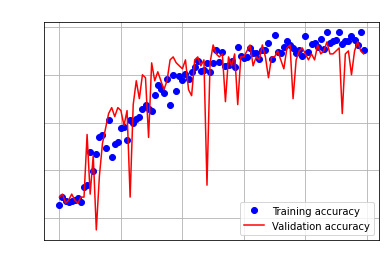

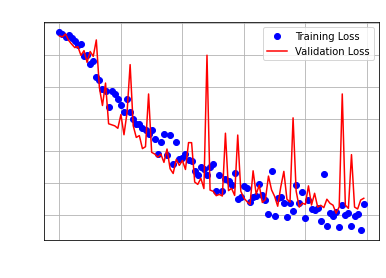

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy', c='white')
plt.xlabel('epochs', c='white')
plt.ylabel('Accuracy', c='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss', c='white')
plt.xlabel('epochs', c='white')
plt.ylabel('Loss', c='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()

plt.grid()
plt.show()

### 8. Let's add the augmentation

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=180,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')



test_datagen = ImageDataGenerator(rescale=1./255)


# Creating the train dataset
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    color_mode = 'grayscale',
                                                    class_mode='binary')

# Creating the validation dataset
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150,150),
                                                        batch_size=20,
                                                        color_mode = 'grayscale',
                                                        class_mode='binary')

# Fit the model
history = model.fit(train_generator,
                   steps_per_epoch=19, # 389 images = batch_size * steps
                   epochs=100,
                   validation_data = validation_generator,
                   validation_steps=8, # 166 images = batch_size * steps
                   verbose=2)

Found 388 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Epoch 1/100
19/19 - 10s - loss: 0.6734 - accuracy: 0.6316 - val_loss: 0.6566 - val_accuracy: 0.6562
Epoch 2/100
19/19 - 10s - loss: 0.6690 - accuracy: 0.6386 - val_loss: 0.6635 - val_accuracy: 0.6375
Epoch 3/100
19/19 - 9s - loss: 0.6683 - accuracy: 0.6359 - val_loss: 0.6574 - val_accuracy: 0.6500
Epoch 4/100
19/19 - 9s - loss: 0.6624 - accuracy: 0.6467 - val_loss: 0.6685 - val_accuracy: 0.6313
Epoch 5/100
19/19 - 10s - loss: 0.6582 - accuracy: 0.6467 - val_loss: 0.6674 - val_accuracy: 0.6313
Epoch 6/100
19/19 - 9s - loss: 0.6557 - accuracy: 0.6413 - val_loss: 0.6370 - val_accuracy: 0.6438
Epoch 7/100
19/19 - 9s - loss: 0.6555 - accuracy: 0.6332 - val_loss: 0.6487 - val_accuracy: 0.6438
Epoch 8/100
19/19 - 9s - loss: 0.6407 - accuracy: 0.6359 - val_loss: 0.6606 - val_accuracy: 0.6375
Epoch 9/100
19/19 - 9s - loss: 0.6293 - accuracy: 0.6359 - val_loss: 0.6693 - val_accuracy: 0.6375
Epoch 10/100
19/19 - 10s

Epoch 82/100
19/19 - 12s - loss: 0.2880 - accuracy: 0.8696 - val_loss: 0.4207 - val_accuracy: 0.8625
Epoch 83/100
19/19 - 12s - loss: 0.3120 - accuracy: 0.8668 - val_loss: 0.9362 - val_accuracy: 0.8250
Epoch 84/100
19/19 - 13s - loss: 0.3165 - accuracy: 0.8777 - val_loss: 0.4113 - val_accuracy: 0.9187
Epoch 85/100
19/19 - 11s - loss: 0.2505 - accuracy: 0.8886 - val_loss: 0.3423 - val_accuracy: 0.8313
Epoch 86/100
19/19 - 12s - loss: 0.2834 - accuracy: 0.8804 - val_loss: 0.4552 - val_accuracy: 0.7750
Epoch 87/100
19/19 - 11s - loss: 0.3125 - accuracy: 0.8913 - val_loss: 0.4796 - val_accuracy: 0.8250
Epoch 88/100
19/19 - 12s - loss: 0.2601 - accuracy: 0.9103 - val_loss: 0.2505 - val_accuracy: 0.9125
Epoch 89/100
19/19 - 13s - loss: 0.2365 - accuracy: 0.9022 - val_loss: 0.5771 - val_accuracy: 0.8938
Epoch 90/100
19/19 - 20s - loss: 0.2680 - accuracy: 0.8967 - val_loss: 0.4314 - val_accuracy: 0.8250
Epoch 91/100
19/19 - 21s - loss: 0.2168 - accuracy: 0.9239 - val_loss: 0.7799 - val_accurac

### 8.2 Potting the accuracy and loss charts

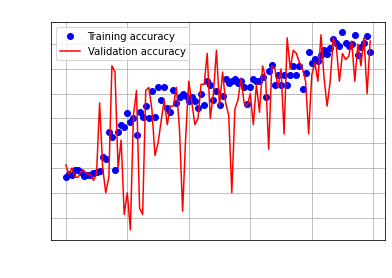

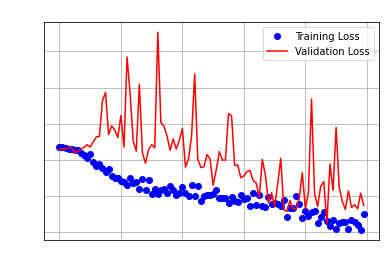

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy', c='white')
plt.xlabel('epochs', c='white')
plt.ylabel('Accuracy', c='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss', c='white')
plt.xlabel('epochs', c='white')
plt.ylabel('Loss', c='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()

plt.grid()
plt.show()

It is a Non-Crack Image

Probability:  [1.1732762e-33]
texture-1504364_640.jpg Prediction: Crack Image


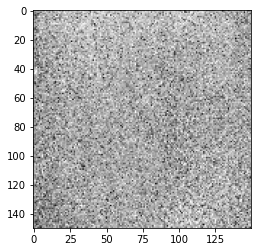

In [53]:
import numpy as np
from keras.preprocessing import image

path = './Image test/'


image_file = path + 'stone-1812348_640.jpg'
img = image.load_img(image_file, target_size=(150,150))
img = img.convert('L')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
plt.imshow(img, cmap='gray')

images = np.vstack([x])
classes = model.predict(images, batch_size=20)
print('It is a Non-Crack Image')
print('\nProbability: ',classes[0])
if classes[0]>0.5:
    print(file + " Prediction: Non-Crack Image")

else:

    print(file + " Prediction: Crack Image")
